# Рекомендация тарифов

Цели проекта

На основе данных о поведении клиентов, Нужно построить и сравнить модели для задачи классификации, которая поможет выбрать подходящий тариф.

* Исследовать разные модели классификации и выбирать лучшую из них (максимально большим значением *accuracy*)
* метрика accuracy на тестовой выборке должна быть не меньше 0.75

План работы:
* [Изучение и оценка данных](#изучение-и-оценка-данных)
* [Разделить исходные данные на обучающую, валидационную и тестовую выборки в соотношении 60-20-20](#разделение-на-выборки)
* [Исследовать качество разных моделей, меняя гиперпараметры](#исследование-моделей)
* [Проверить качество модели на тестовой выборке](#проверка-лучшей-модели-на-тестовой-выборке)
* [Проверить модель на вменяемость](#провека-модели-на-адекватность)
* [Выводы](#вывод)


Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Изучение и оценка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.datasets import load_iris
from sklearn import tree

In [2]:
df = pd.read_csv('C:\\Users\\Freo\\Desktop\\projects\\datasets\\p5.csv')

In [3]:
display(df)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
print(df.columns)

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')


посмотрим на сбалансированность:

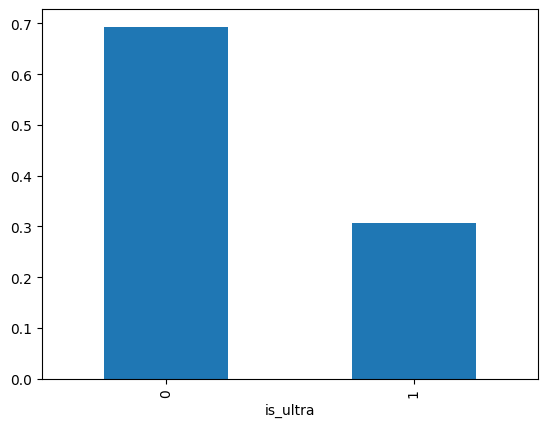

In [5]:
df['is_ultra'].value_counts(normalize=True).plot(kind='bar');

визуально видно сильное смещение в сторону тарифа "смарт"; даже если просто предсказывать что у каждого человеека смарт - мы будем правы примерно в 68~% случаев; значит необходимо получить от модели более точное предсказание

### Разделение на выборки

разделим сначала на 2 части, обучающую выборку и временную в соотношении 60 \ 40

временную затем поделим пополам, что в итоге даст соотношение 60-20-20

In [6]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']


features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify = target)




features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345, stratify = target_temp)

удостоверимся что размеры верны

In [7]:
print(len(df))
print(len(features_train))
print(len(features_valid))
print(len(features_test))
print(len(df) == len(features_train)+len(features_test)+len(features_test))

3214
1928
643
643
True


### Исследование моделей

сравним

* дерево решений
* случайный лес
* логистическую регрессию

дерево:

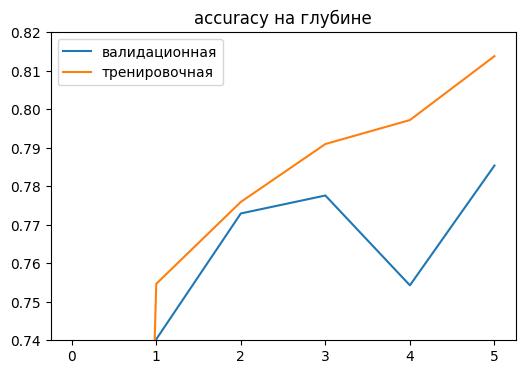

Accuracy лучшей модели:, 0.7853810264385692, на глубине 5


In [8]:
for_plot_val = [0]
for_plot_train = [0]
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth= depth)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    
    for_plot_val.append(result)
    for_plot_train.append(model.score(features_train, target_train))

    if result > best_result:
        best_model_dt = model
        best_result = result
        best_depth = depth

fig, ax = plt.subplots()
plt.title('accuracy на глубине')
ax.plot(for_plot_val, label = 'валидационная')
ax.plot(for_plot_train, label = 'тренировочная')
plt.ylim([0.74, 0.82]);
ax.legend()

fig.set_figheight(4)
fig.set_figwidth(6)
plt.show()

print(f'Accuracy лучшей модели:, {best_result}, на глубине {best_depth}')

Визуализируем основные критерии классификации

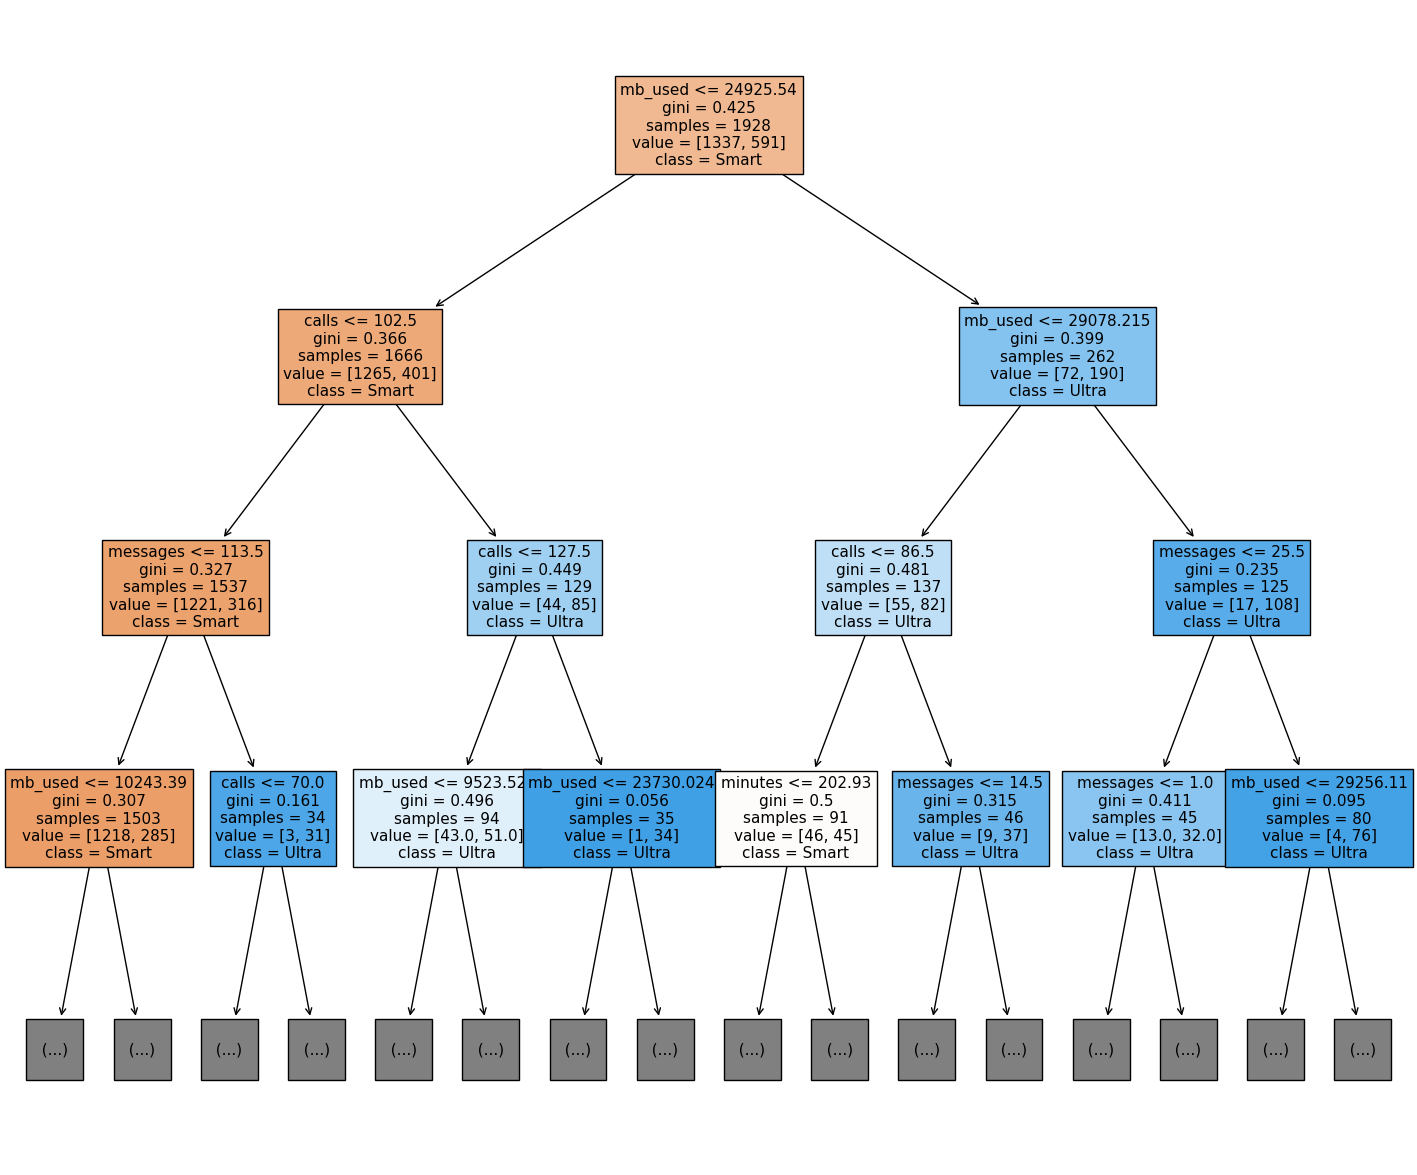

In [9]:
plt.figure(figsize=(18,15))
tree.plot_tree(model, max_depth=3, fontsize=11, feature_names = features_train.columns, class_names=['Smart','Ultra'], filled=True);
plt.show()

случайный лес:

In [10]:
%%time
criterions = ['gini','entropy']
best_model = None
best_result = 0
best_depth = 0

for est in range(10, 51, 10):
    for depth in range(1, 11):
        for criter in criterions:
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth, criterion = criter)           
            model.fit(features_train, target_train)
            result = model.score(features_valid, target_valid)
            
            if result > best_result:
                best_model_rf = model
                best_result = result
                best_est = est
                best_depth = depth
                best_criter = criter
               
print(f'Accuracy наилучшей модели:{best_result}, деревьев: {best_est}, глубина: {best_depth}, критерий: {best_criter}')

Accuracy наилучшей модели:0.8211508553654744, деревьев: 40, глубина: 9, критерий: gini
CPU times: total: 8.97 s
Wall time: 9 s


In [11]:
y_train = df['is_ultra']
X_train = df.drop('is_ultra', axis=1)

clf = RandomForestClassifier(random_state=12345)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,11)
            }

In [12]:
%%time
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'max_depth': 9, 'n_estimators': 50}
CPU times: total: 24.5 s
Wall time: 24.4 s


логистическая регрессия:

In [13]:
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

best_model = None
best_result = 0
best_iter = 0

for solv in solvers:
    model = LogisticRegression(random_state=12345, solver=solv)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
            best_model_lr = model# сохраним наилучшую модель
            best_result = result#  сохраним наилучшее значение метрики accuracy на валидационных данных
            best_solver = solv
print(f'Accuracy наилучшей модели на валидационной выборке: {best_result}, солвер = {best_solver}')
            

Accuracy наилучшей модели на валидационной выборке: 0.7387247278382582, солвер = newton-cg


c:\Users\Freo\Desktop\projects\my_venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Freo\Desktop\projects\my_venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Проверка лучшей модели на тестовой выборке

Обьединим обучающую и валидационную выборки для увеличения обьема данных для обучения

In [14]:
features_80 = pd.concat([features_train, features_valid])
target_80 = pd.concat([target_train, target_valid])

было

In [15]:
result = best_model_rf.score(features_test, target_test)
print(f'accuracy на тестовой: {result}')

accuracy на тестовой: 0.8087091757387247


стало

In [16]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth = 9)
model.fit(features_80, target_80) 
result = model.score(features_test, target_test)
print(f'accuracy на тестовой: {result}')

accuracy на тестовой: 0.8289269051321928


Обьединением тренерировочной и валидационной удалость добавить еще пару процентов для интересующей нас метрики accuracy

### Провека модели на адекватность

Чтобы оценить адекватность модели сравним её с моделью которая выбирает самый распространный в обучающей выборке вариант:

In [17]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
print(dummy_clf.score(features_test, target_test))


0.6936236391912908


Наша модель показала результаты лучше

### Вывод

Получив данные о поведении клиентов мы разделили их на 3 стратифицированные выборки; для обучения модели, выбора и настройки модели которая сможет наиболее успешно предсказывать новые данные на основе уже имеющихся, для итоговой проверки соотвествия минимально необходимым критериям точности.

для проверки было выбрано 3 модели: решающее дерево, случайный лес и логистическая регрессия. Подбирая гиперпараметры, наилучший результат показала модель "случайный лес" (глубина = 9, количество деревьев = 40)

После проверки на заранее подготовленной тестовой выборке удостоверились что условия (accuracy > 75) были соблюдены; после дообучения на валидационной выборке точность прогноза составила почти 83%

Дополнительно проверили модель на адекватность сравнив с простановкой наиболее частых ответов; наша модель показала результаты лучше (83% против 69%)
